# Person of Interest Model
## Udacity's Introduction to Machine Learning course
###### By aaraeus

**Other helpful repositories to learn from which helped me in March 2019**
- https://github.com/tybyers/Udacity_IntroMachineLearning/blob/master/Question_Responses.ipynb

- https://github.com/soukiassianb/Udacity-Machine-Learning-Enron-Dataset/blob/master/poi_id.ipynb

- https://devpost.com/software/enron-identify-fraud

# Table of Contents
- [Introduction](#Introduction)
- [Section 1: Initialisation, data loading and imports](#Section1)
- [Section 2: Outlier identification & removal](#Section2)
- [Section 3: Create new features](#Section3)
- [Section 4: Feature Selection](#Section4)
- [Section 5: Model Data Preparation](#Section5)
- [Section 6: Classifier Selection and Testing](#Section6)
- [Section 7: Parameter Tuning](#Section7)
- [Section 8: Final model creation](#Section8)
- [Conclusion](#Conclusion)

<a id='Introduction'></a>

## Introduction
The goal here is to identify whether someone might be a person of interest in a fraud investigation into the Enron scandal. Enron was a company that committed a large amount of fraudulent activities, effectively rigging the market to create profit. The question we are trying to solve is, what other people, aside from the people already identified as a POI from previous litigation action, could have been actively and knowingly involved? Since we have a large amount of open data, including emails, we can train a machine learning model to look at these features and attempt to predict whether someone is a person of interest or not.

<a id='Section1'></a>

## Section 1: Initialisation, data loading and imports

Here we're just initialising the working directory to make editing items a little easier. I've placed all the features into their own lists, and then created a final features list to work with.

In [1]:
# Important - this is the path of our directory, where this project/code is saved and located, 
# as well as the tester file!
path = '/Users/kintesh/Documents/udacity_ml/python3'

import sys
import pickle
import os
import pandas as pd
import matplotlib.pyplot
import seaborn as sn
import numpy as np

os.chdir(path)

sys.path.append("ud120-projects/tools/")
sys.path.append("ud120-projects/final_project/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

financial_features_list = ["salary", "deferral_payments", "total_payments", "loan_advances", 
                           "bonus", "restricted_stock_deferred", "deferred_income", 
                           "total_stock_value", "expenses", "exercised_stock_options", 
                           "other", "long_term_incentive", "restricted_stock", "director_fees"]

email_features_list = ["to_messages", "from_poi_to_this_person",
                       "from_messages", "from_this_person_to_poi", "shared_receipt_with_poi"]

target_label = ["poi"]

full_features_list = target_label + financial_features_list + email_features_list
features_list = financial_features_list + email_features_list
financial_features_list = target_label + financial_features_list
email_features_list = target_label + email_features_list

### Load the dictionary containing the dataset
data_dict = pickle.load(open("ud120-projects/final_project/final_project_dataset.pkl", "rb") )

<a id='Section2'></a>

## Section 2: Outlier identification & removal

The first step of any machine learning project is to start graphing some data to check for outliers. The most obvious starting point is to chart salary and bonus as we did earlier in the course, so let's do that first.

There are two obvious outliers. "The Travel Agency In The Park" isn't a persion, so let's remove this.

Also, "Mr Eugene E Lockhart" doesn't contribute anything to the dataset since his values are all empty!

Mr Lockhart's values:
{'salary': 'NaN', 'to_messages': 'NaN', 'deferral_payments': 'NaN', 'total_payments': 'NaN', 'loan_advances': 'NaN', 'bonus': 'NaN', 'email_address': 'NaN', 'restricted_stock_deferred': 'NaN', 'deferred_income': 'NaN', 'total_stock_value': 'NaN', 'expenses': 'NaN', 'from_poi_to_this_person': 'NaN', 'exercised_stock_options': 'NaN', 'from_messages': 'NaN', 'other': 'NaN', 'from_this_person_to_poi': 'NaN', 'poi': False, 'long_term_incentive': 'NaN', 'shared_receipt_with_poi': 'NaN', 'restricted_stock': 'NaN', 'director_fees': 'NaN'}


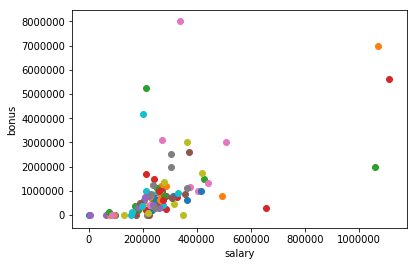

In [2]:
### Task 2: Remove outliers
features = ["salary", "bonus"]

# Remove the TOTAL key, since this is going to skew our results. Also remove the 
#"travel agency in the park" record since that isn't a person.
print("Mr Lockhart's values:")
print(data_dict['LOCKHART EUGENE E'])

data_dict.pop('TOTAL', 0)
data_dict.pop("THE TRAVEL AGENCY IN THE PARK", 0)
data_dict.pop('LOCKHART EUGENE E', 0)

data = featureFormat(data_dict, features)

for point in data:
    salary = point[0]
    bonus = point[1]
    matplotlib.pyplot.scatter( salary, bonus )

matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()

In [3]:
# Who are these people on the top right of the plot above? Loop through everyone, 
# and output those that have salaries above 600k and bonuses above 4m.

#First, find salary outliers.
print('-'*20)
print('Salary outliers:')
print('-'*20)
for names, value in data_dict.items():
    if data_dict[names]["salary"] != 'NaN' and data_dict[names]["salary"] >= 600000:
        print("Name: ", names)
        print("Salary: ", value['salary'])
    
print('-'*20)
print('Bonus outliers:')
print('-'*20)

#Second, find bonus outliers.
for names, value in data_dict.items():
    if data_dict[names]["bonus"] != 'NaN' and data_dict[names]["bonus"] >= 4000000:
        print("Name: ", names)
        print("Bonus: ", value['bonus'])
        
print('-'*20)
print('Salary & Bonus outliers:')
print('-'*20)

#Third, look at the combination of the two.
for names, value in data_dict.items():
    if data_dict[names]["bonus"] != 'NaN' and data_dict[names]["bonus"] >= 4000000 and data_dict[names]["salary"] != 'NaN' and data_dict[names]["salary"] >= 600000:
        print("Name: ", names)
        print("Salary: ", value['salary'])
        print("Bonus: ", value['bonus'])

--------------------
Salary outliers:
--------------------
Name:  LAY KENNETH L
Salary:  1072321
Name:  SKILLING JEFFREY K
Salary:  1111258
Name:  PICKERING MARK R
Salary:  655037
Name:  FREVERT MARK A
Salary:  1060932
--------------------
Bonus outliers:
--------------------
Name:  LAVORATO JOHN J
Bonus:  8000000
Name:  LAY KENNETH L
Bonus:  7000000
Name:  BELDEN TIMOTHY N
Bonus:  5249999
Name:  SKILLING JEFFREY K
Bonus:  5600000
Name:  ALLEN PHILLIP K
Bonus:  4175000
--------------------
Salary & Bonus outliers:
--------------------
Name:  LAY KENNETH L
Salary:  1072321
Bonus:  7000000
Name:  SKILLING JEFFREY K
Salary:  1111258
Bonus:  5600000


Here I'm making a judgement call to keep these people, like Kenneth Lay and Jevvrey Skilling, in our dataset. The people with the highest salaries were, in fact, POIs, so it does make sense to keep them in the data, despite the fact that they are outliers and may skew our model slightly. Models can never be completely rid of bias.

<a id='Section3'></a>

## Section 3: Create new features

Here, we're creating new features and adding their name to our features_list.

Create some new features below and test them out in our feature importance list.

I want to create:

1. A Salary Ratio, which is your salary as a % of total payments. Are people who had a low salary ratio (i.e. had ridiculously high total payments) more likely to be a POI? Kenneth Lay certainly did.

2. Expenses ratio, so the expenses as a % of the total salary. Did people who had higher expenses get cozy in the knowledge that they'd uncovered something special? 

3. Exercised Stock Ratio, which is exercised stock options as a proportion of total stock (exercised stock options, restricted stock, restricted stock deferred). Maybe people who knew about the 'scam' tried to exercise all their stock towards the fall of Enron?

In [4]:
### Task 3: Create new feature(s)

for person in data_dict:
    # Salary Ratio
    if data_dict[person]['salary'] == 'NaN' or data_dict[person]['total_payments'] == 'NaN':
            data_dict[person]['salary_ratio'] = '0'
    else:
        data_dict[person]['salary_ratio'] = float(data_dict[person]['salary']) / float(data_dict[person]['total_payments'])
    
    # Expenses Ratio
    if data_dict[person]['expenses'] == 'NaN' or data_dict[person]['salary'] == 'NaN':
            data_dict[person]['expenses_ratio'] = '0'
    else:
        data_dict[person]['expenses_ratio'] = float(data_dict[person]['expenses']) / float(data_dict[person]['salary'])        
    
    # Exercised Stock Ratio
    if data_dict[person]['exercised_stock_options'] == 'NaN' or data_dict[person]['total_stock_value'] == 'NaN':
            data_dict[person]['exercised_stock_ratio'] = '0'
    else:
        data_dict[person]['exercised_stock_ratio'] = float(data_dict[person]['exercised_stock_options']) / float(data_dict[person]['total_stock_value'])

# Add these features to my features_list
features_list.append('salary_ratio')
features_list.append('expenses_ratio')
features_list.append('exercised_stock_ratio')

In [5]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

# Print features_list and an example, to make sure the data has our created features in it.
print('-'*30)
print('Features_list:')
print('-'*30)
print(features_list)

print('-'*30)
print('Keys in "my_dataset":')
print('-'*30)

for key in my_dataset[person].keys():
    print(key)

------------------------------
Features_list:
------------------------------
['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'salary_ratio', 'expenses_ratio', 'exercised_stock_ratio']
------------------------------
Keys in "my_dataset":
------------------------------
salary
to_messages
deferral_payments
total_payments
loan_advances
bonus
email_address
restricted_stock_deferred
deferred_income
total_stock_value
expenses
from_poi_to_this_person
exercised_stock_options
from_messages
other
from_this_person_to_poi
poi
long_term_incentive
shared_receipt_with_poi
restricted_stock
director_fees
salary_ratio
expenses_ratio
exercised_stock_ratio


<a id='Section4'></a>

## Section 4: Feature Selection

Let's use SelectPercentile to find the top x% variables.

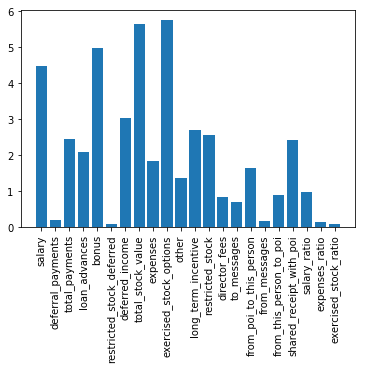

salary:  4.458636238488813
deferral_payments:  0.19635060312299754
total_payments:  2.4449870742699775
loan_advances:  2.0845025040037384
bonus:  4.958094860652936
restricted_stock_deferred:  0.09779108176680255
deferred_income:  3.035251788309274
total_stock_value:  5.61900858422821
expenses:  1.8309666095033812
exercised_stock_options:  5.740357181466678
other:  1.3707765246201635
long_term_incentive:  2.7002353724637613
restricted_stock:  2.543208542735528
director_fees:  0.8326498339070421
to_messages:  0.6955899398546326
from_poi_to_this_person:  1.6286759410029752
from_messages:  0.1668507833133156
from_this_person_to_poi:  0.9033205384408002
shared_receipt_with_poi:  2.40386464353768
salary_ratio:  0.9855931657286244
expenses_ratio:  0.1385905819491767
exercised_stock_ratio:  0.07691494332921386


In [6]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, target_label + features_list, sort_keys = True)
l, f = targetFeatureSplit(data)

# First, try using SelectKBest to find the best features.
from sklearn.feature_selection import SelectKBest, f_classif, SelectPercentile

# Perform feature selection
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(f, l)

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores. 
matplotlib.pyplot.bar(range(len(features_list)), scores)
matplotlib.pyplot.xticks(range(len(features_list)), features_list, rotation='vertical')
matplotlib.pyplot.show()

for i,j in zip(features_list,scores):
    print(i + ": ", str(j))

From the SelectPercentile list, the most important features seem to be:

["salary", "bonus", "exercised_stock_options", "total_stock_value", "deferred_income"]

Update our features_list accordingly, and use this as a basic list to trial for a few models.

Initially, I went for a larger feature list and tried to include my 3 new variables. FYI, here are the results:


<a id='Section5'></a>

## Section 5: Model Data Preparation

In this section, we're going to create a *model_features_list* and subset our initial dictionary. Remember to keep POI at the beginning of the data, that's pretty important.

Here's the StackOverflow page where I learned how to use SSS:
https://stackoverflow.com/questions/29438265/stratified-train-test-split-in-scikit-learn

In [7]:
model_features_list =  ["salary", "bonus", "exercised_stock_options", "total_stock_value", "deferred_income"]

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, target_label + model_features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

print("Number of labels in our labels data:")
print(sum(labels)*1.0)

print("Number of people in our overall data:")
print(len(features)*1.0)

Number of labels in our labels data:
18.0
Number of people in our overall data:
139.0


<a id='Section6'></a>

## Section 6: Classifier Selection and Testing

Classifier selection is tricky. Let's try out a bunch of classifiers and append to a dataset manually to compare some results! What gives us a decent enough accuracy score?

Using SSS:
https://stackoverflow.com/questions/46598301/how-to-compute-precision-recall-and-f1-score-of-an-imbalanced-dataset-for-k-fold

In [8]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,confusion_matrix

sss = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.33)

# Check for just one example before we try to loop.
# clf_name = "Random Forest"
# clf_obj = RandomForestClassifier(n_estimators=10)

# Loop version

clf_names = [
    "DecisionTree"
    ,"RandomForest"
#     ,"SVM"
    ,"GuassianNB"
#     ,"KMeans"
    ,"AdaBoost"
    ,"KNearestNeighbours"
]

clf_objects = [
    DecisionTreeClassifier()
    ,RandomForestClassifier(n_estimators=10)
#     ,svm.SVC(gamma='auto')
    ,GaussianNB()
#     ,KMeans()
    ,AdaBoostClassifier()
    ,KNeighborsClassifier()
]

clf_features = model_features_list

# Create a clf_results_df as empty first before we start looping.
clf_results_df = pd.DataFrame(columns=['clf_name',
                                       'precision','recall','accuracy','f1_score'])

for clf_name, clf_obj in zip(clf_names, clf_objects):
    scoring = {'accuracy' : make_scorer(accuracy_score), 
               'precision' : make_scorer(precision_score),
               'recall' : make_scorer(recall_score), 
               'f1_score' : make_scorer(f1_score)}

    results = cross_validate(estimator=clf_obj,
                                X=features,
                                y=labels,
                                cv=sss,
                                scoring=scoring)

# Load this data into a temporary pandas dataframe
    scores_df = pd.DataFrame()
    scores_df['clf_name'] = [clf_name]
#     scores_df['clf_features'] = [clf_features]

    scores_df['precision'] = np.mean(results['test_precision'])
    scores_df['recall'] = [np.mean(results['test_recall'])]
    scores_df['accuracy'] = [np.mean(results['test_accuracy'])]
    scores_df['f1_score'] = [np.mean(results['test_f1_score'])]

    # Make the clf_name the index of this dataframe
    scores_df.set_index('clf_name')

    clf_results_df = clf_results_df.append(scores_df, sort='False')

# Do some final formatting to the table, and output the feature list to show how this list performs against each CLF.
print('-'*30)
print("Overall results: ")
print('-'*30)
clf_results_final = clf_results_df.transpose()

clf_results_final.columns = clf_names
clf_results_final.drop(['clf_name'], inplace=True)

print('Features used:', clf_features)
print(clf_results_final.to_string())

# print(clf_results_final)

------------------------------
Overall results: 
------------------------------
Features used: ['salary', 'bonus', 'exercised_stock_options', 'total_stock_value', 'deferred_income']
          DecisionTree RandomForest GuassianNB  AdaBoost KNearestNeighbours
accuracy      0.847826     0.869565   0.891304  0.869565           0.847826
f1_score      0.363636         0.25   0.545455       0.4                  0
precision          0.4          0.5        0.6       0.5                  0
recall        0.333333     0.166667        0.5  0.333333                  0


###### The above cell was rerun with multiple feature lists, to show the impact of adding the created 

```python
------------------------------
Overall results: 
------------------------------
Features used: ['salary', 'bonus', 'exercised_stock_options', 'total_stock_value', 'deferred_income']
          DecisionTree RandomForest GuassianNB  AdaBoost KNearestNeighbours
accuracy      0.847826     0.891304   0.891304  0.869565           0.847826
f1_score      0.363636     0.444444   0.545455       0.4                  0
precision          0.4     0.666667        0.6       0.5                  0
recall        0.333333     0.333333        0.5  0.333333                  0

------------------------------
With salary_ratio: 
------------------------------
Features used: ['salary', 'bonus', 'exercised_stock_options', 'total_stock_value', 'deferred_income', 'salary_ratio']
          DecisionTree RandomForest GuassianNB  AdaBoost KNearestNeighbours
accuracy      0.826087     0.913043   0.891304  0.804348           0.847826
f1_score      0.333333          0.5   0.545455  0.307692                  0
precision     0.333333            1        0.6  0.285714                  0
recall        0.333333     0.333333        0.5  0.333333                  0

------------------------------
With expenses_ratio: 
------------------------------
Features used: ['salary', 'bonus', 'exercised_stock_options', 'total_stock_value', 'deferred_income', 'expenses_ratio']
          DecisionTree RandomForest GuassianNB  AdaBoost KNearestNeighbours
accuracy      0.847826     0.891304   0.891304  0.869565           0.847826
f1_score      0.222222     0.444444   0.545455       0.4                  0
precision     0.333333     0.666667        0.6       0.5                  0
recall        0.166667     0.333333        0.5  0.333333                  0

------------------------------
With exercised_stock_ratio: 
------------------------------
Features used: ['salary', 'bonus', 'exercised_stock_options', 'total_stock_value', 'deferred_income', 'exercised_stock_ratio']
          DecisionTree RandomForest GuassianNB  AdaBoost KNearestNeighbours
accuracy      0.826087     0.869565   0.891304  0.804348           0.847826
f1_score      0.333333         0.25   0.545455  0.307692                  0
precision     0.333333          0.5        0.6  0.285714                  0
recall        0.333333     0.166667        0.5  0.333333                  0
```

It looks like the best models to use, based on our initial *model_features_list*, are:

1. Decision Tree
2. Random Forest
3. Gaussian NB
4. Adaboost

Though in terms of lists, adding our 3 created variables didn't really do much apart from increasing , so we'll just keep the original list.

<a id='Section7'></a>

## Section 7: Parameter Tuning

Tune the parameters. Maybe try GridsearchCV as explained here on Kaggle:

https://www.kaggle.com/evanmiller/pipelines-gridsearch-awesome-ml-pipelines

In [9]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

pipeline = Pipeline([
#         ('clf', AdaBoostClassifier())
#         ('clf', DecisionTreeClassifier())
        ('clf', RandomForestClassifier())
#         ('clf', GaussianNB())

    ])

parameters = {
#         ADABOOST
#         'clf__algorithm': ['SAMME', 'SAMME.R'],
#         'clf__n_estimators': [25, 50, 100],
#         'clf__learning_rate': [.5, 1., 1.5]
    
#         DECISION TREE
#           'clf__max_depth': [3, 6, 9, 12, 15, 20],
#           'clf__min_samples_leaf': [1, 5, 10, 20, 50, 100]

#         RANDOM FOREST
        'clf__n_estimators': [25, 30, 50, 80, 100],
        'clf__min_samples_split': [2, 4, 6, 8, 10],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [3, 6, 9, 12, 15, 20]
    
        # GAUSSIAN NB
        # None, since GaussianNB only requires 'prior' as a thingie.
}

CV = GridSearchCV(pipeline, parameters, scoring = 'f1', cv=sss)

CV.fit(features, labels)   

print('Best score and parameter combination = ')

print(CV.best_score_)    
print(CV.best_params_)   

Best score and parameter combination = 
0.6
{'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 25}


Results of each algorithm through the GridSearchCV are as follows:
```Python

Adaboost:
Best score and parameter combination = 
0.4444444444444444
{'clf__algorithm': 'SAMME', 'clf__learning_rate': 1.0, 'clf__n_estimators': 25}

Decision Tree: (no predicted samples present)
Best score and parameter combination = 
0.4444444444444444
{'clf__max_depth': 3, 'clf__min_samples_leaf': 5}

Random Forest: (no predicted samples present)
Best score and parameter combination = 
0.6666666666666666
{'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__min_samples_split': 6, 'clf__n_estimators': 25}
    

Gaussian NB:
Best score and parameter combination = 
0.5454545454545454
{}
```

So from our 3 tunable classifiers, the two that worked out the best for maximising f1_score were Random Forest and Gaussian NB. Since the Random Forest didn't turn up with any predicted values, I'm going to go ahead and dump that one too. Let's go with GaussianNB.

<a id='Section8'></a>

## Section 8: Final model creation

Pick the best model from the above iterations and go with that.

In [13]:
clf = GaussianNB()
# clf.fit(feature_train, target_train)

# pred = clf.predict(feature_test)

clf_name = 'Gaussian NB'
clf_parameters = "None"
clf_features = ",".join(model_features_list)

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

results = cross_validate(estimator=clf,
                            X=features,
                            y=labels,
                            cv=sss,
                            scoring=scoring)

#     print(results)

#     Load this data into a temporary pandas dataframe
final_model_scores_df = pd.DataFrame()
final_model_scores_df['clf_name'] = [clf_name]
final_model_scores_df['clf_features'] = [clf_features]

final_model_scores_df['precision'] = np.mean(results['test_precision'])
final_model_scores_df['recall'] = [np.mean(results['test_recall'])]
final_model_scores_df['accuracy'] = [np.mean(results['test_accuracy'])]
final_model_scores_df['f1_score'] = [np.mean(results['test_f1_score'])]

print(final_model_scores_df.to_string())

      clf_name                                       clf_features  precision  recall  accuracy  f1_score
0  Gaussian NB  salary,bonus,exercised_stock_options,total_sto...        0.6     0.5  0.891304  0.545455


In [11]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, target_label + model_features_list)

# pickle.dump(clf, open("my_classifier.pkl", "wb") )
# pickle.dump(data_dict, open("my_dataset.pkl", "wb") )
# pickle.dump(model_features_list, open("my_feature_list.pkl", "wb") )

Final tester results for Random Forest:
``` python
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

	Accuracy: 0.86500	Precision: 0.56707	Recall: 0.23250	F1: 0.32979	F2: 0.26361
	Total predictions: 14000	True positives:  465	False positives:  355	False negatives: 1535	True negatives: 11645

```
Final tester results for NB:
``` python

GaussianNB(priors=None, var_smoothing=1e-09)
	Accuracy: 0.85464	Precision: 0.48876	Recall: 0.38050	F1: 0.42789	F2: 0.39814
	Total predictions: 14000	True positives:  761	False positives:  796	False negatives: 1239	True negatives: 11204
```

## Conclusion

Conclusion text here.